## Importing Packages

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg
%matplotlib inline

## Camera Calibration

In [2]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

## UnDistortion Function

In [3]:
def undistort_image(image):
    img_size = (image.shape[1], image.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    return cv2.undistort(image, mtx, dist, None, mtx)
#test for the function
test_image = cv2.imread(images[0])
cv2.imwrite('./output_images/chessboard_before_distortion.jpg', test_image)
cv2.imwrite('./output_images/chessboard_after_distortion.jpg', undistort_image(test_image))

True

## Get Images

In [4]:
images = []
data_path = 'test_images/'
out_path = 'output_images/'
for file in os.listdir(data_path):
    if '.jpg' in file:
        image = mpimg.imread(data_path + file)
        images.append(image)

## Show Images Function

In [5]:
def showImages(process,num=len(images), show_gray=False):
    for i, image in enumerate(images[0:num]):
        f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,15))
        ax1.set_title('Original Image')
        ax1.imshow(image) 
        ax2.set_title('Processed Image')   
        processed = process(image)
        if show_gray:
            ax2.imshow(processed, 'gray')
        else:
            ax2.imshow(processed)
        plt.show()

## Compare between normal images and undistorted images

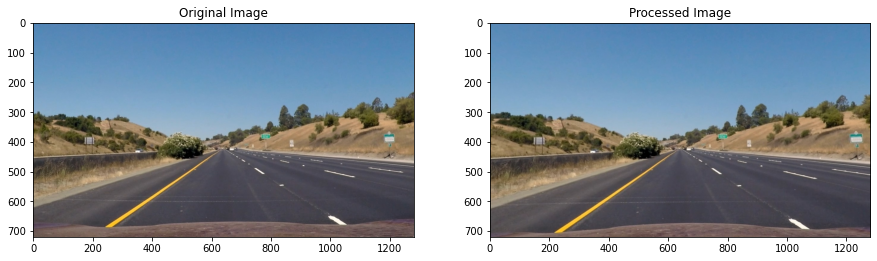

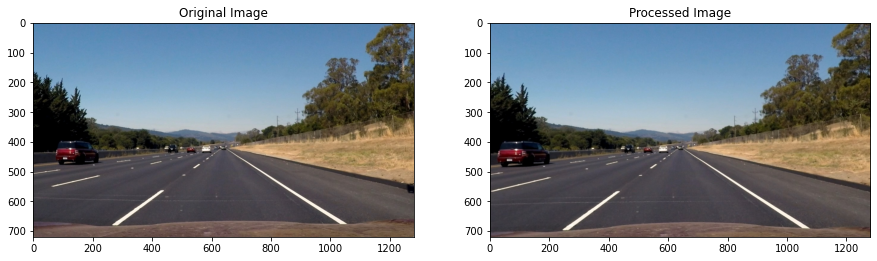

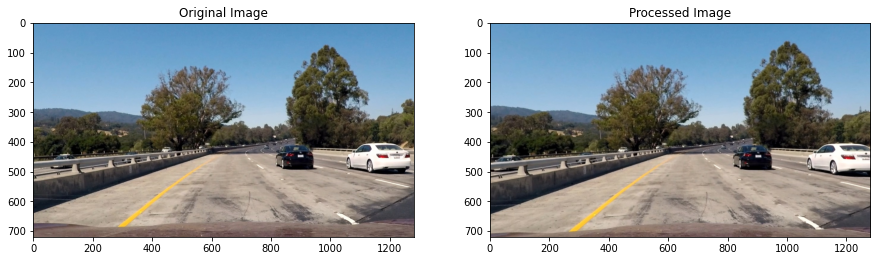

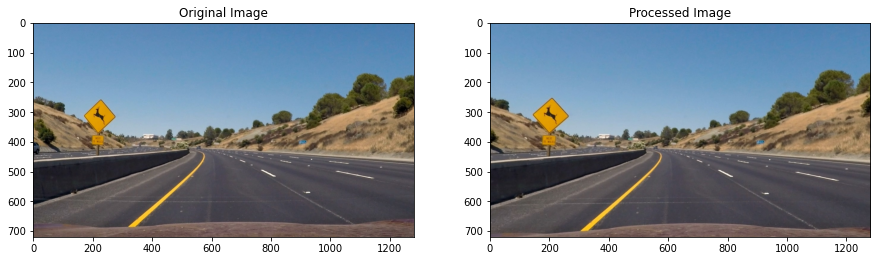

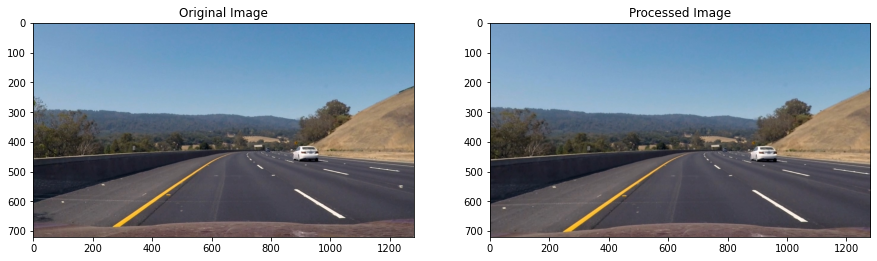

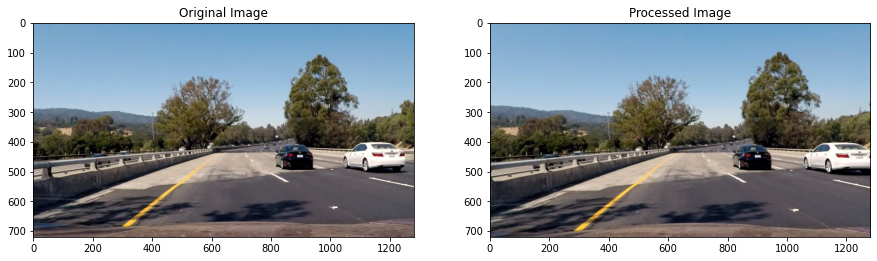

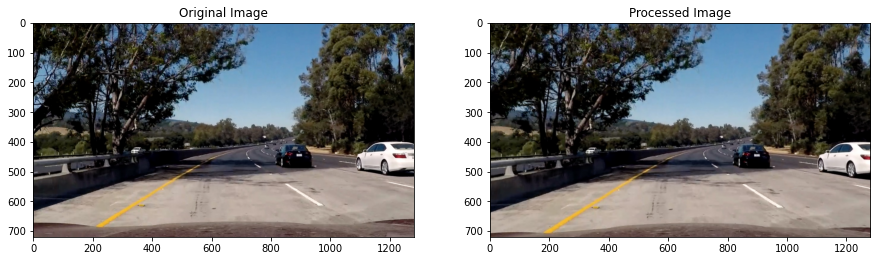

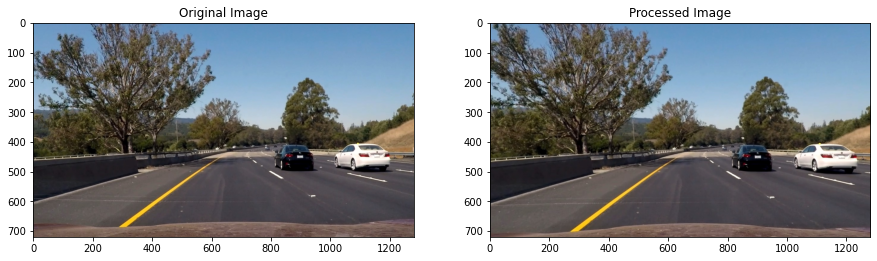

In [6]:
showImages(undistort_image)

In [7]:
## Edge deection using sobel 

def abs_sobel(image, direction='x', kernel_size=3, thresh_range=(0, 255)):

    # Convert to gray scale image 
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient then take the absolute
    if direction == 'x':
        sobel_x=cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size)
        abs_sobel= np.absolute(sobel_x)
    if direction == 'y':
        sobel_y = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size)
        abs_sobel = np.absolute(sobel_y)
        
    # Convert to 'cv2.CV_8U'.
    sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Take the same shape and with setting it's values to 0
    binary_img = np.zeros_like(sobel)
    binary_img[(sobel >= thresh_range[0]) & (sobel <= thresh_range[1])] = 1
    
    # Black and white output image
    return binary_img
    
    
def calc_mag_thresh(image, kernel_size=3, thresh_range=(0, 255)):

    # Convert to grayscale
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Calculate Sobel x and y gradients
    sobel_x = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobel_y = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size)
    # Calculate the gradient magnitude 
    mag_grad = np.sqrt(sobel_x**2 + sobel_y**2)
    # Convert to 'cv2.CV_8U'.
    factor = np.max(mag_grad)/255 
    mag_grad = (mag_grad/factor).astype(np.uint8) 
    # Take the same shape and with setting it's values to 0
    binary_img = np.zeros_like(mag_grad)
    binary_img[(mag_grad >= thresh_range[0]) & (mag_grad <= thresh_range[1])] = 1

    # Black and white output image
    return binary_img    


    
    
    


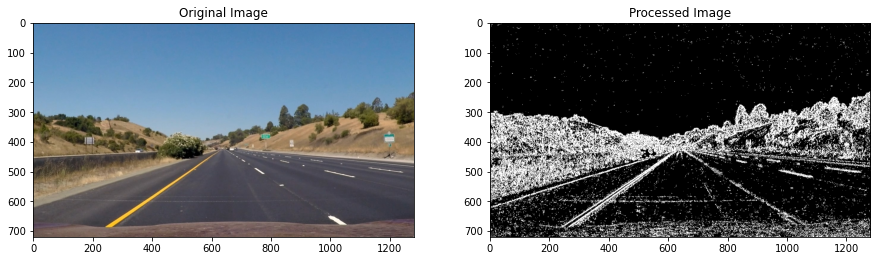

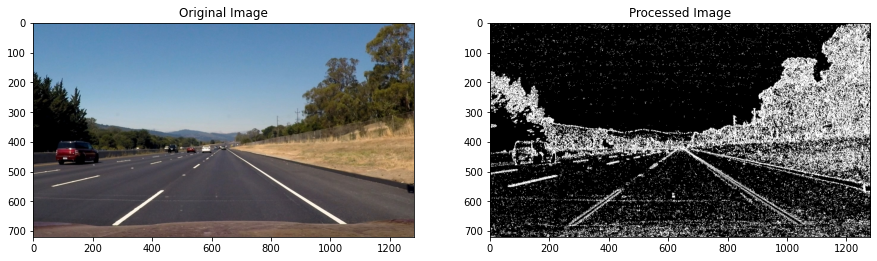

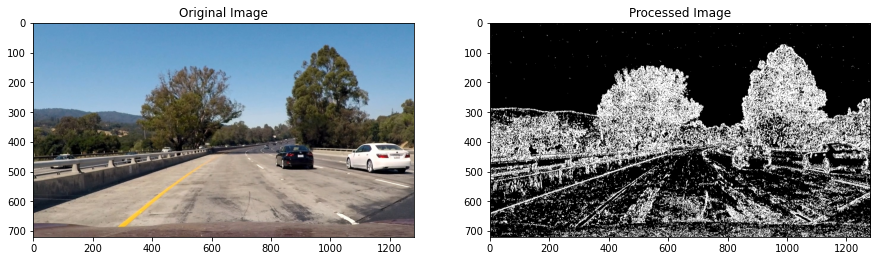

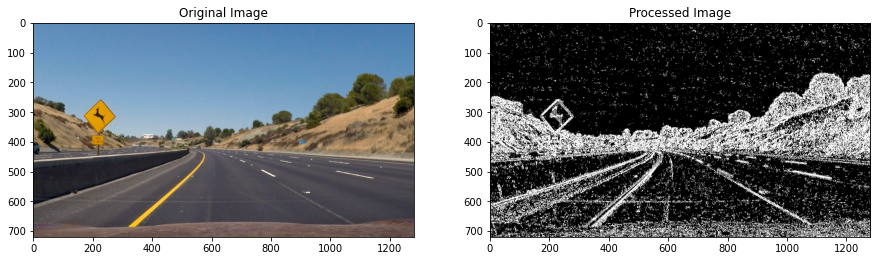

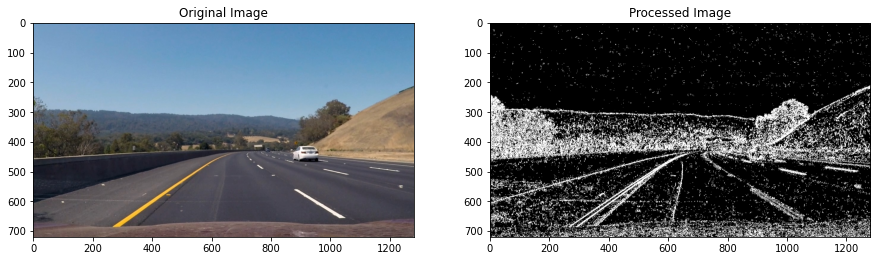

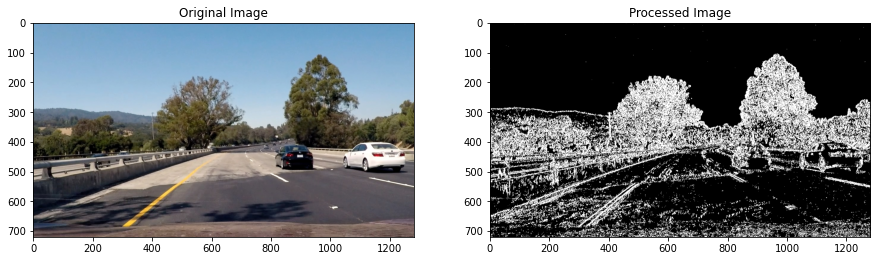

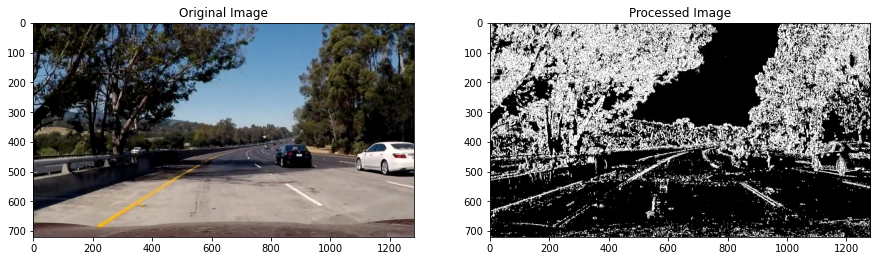

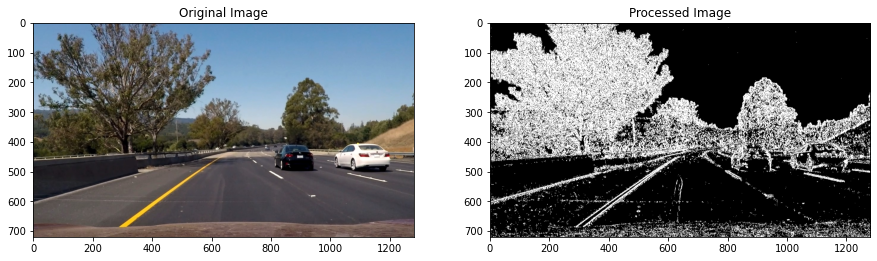

In [13]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):

    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    binary_image_output =  np.zeros_like(absgraddir)
    binary_image_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_image_output

def combined_thresholds(image, ksize = 3):
    # Choose a Sobel kernel size
    # Apply each of the thresholding functions
    gradx = abs_sobel(image, direction='x',kernel_size=ksize, thresh_range=(5, 100))
    mag_binary = calc_mag_thresh(image, kernel_size=ksize, thresh_range=(3, 255))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(45*np.pi/180, 75*np.pi/180)) 
    combined = np.zeros_like(dir_binary, np.uint8)    
    combined[((gradx == 1) | (gradx == 1)) & ((mag_binary == 1) | (dir_binary == 1))] = 1
    return combined
showImages(combined_thresholds,show_gray=True)    